#  1. 데이터 살펴보기(EDA)
✓ 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 하이퍼 파라미터를 튜닝하며 최적의 조합찾기

EDA 과정을 통해 불필요한 피처를 골라내거나 적절하게 피처를 수정하는 등의 피처 엔지니어링을 진행함으로써 데이터를 정제하는 것이 매우 중요하다

 다양한 방법론 중 하이퍼 파라미터 튜닝에 집중해서 모델의 성능을 최대한 끌어올려보지만, 튜닝은 최적화 방법 중 하나일 뿐

~~~
 # gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(random_state=random_state)
# lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)
~~~

의사 결정나무 (decision tree) 방식을 활용하는 LightGBM, XGBoost, Catboost 등의 기계학습 방법이 소위 딥러닝 방법보다 더 뛰어난 성능을 발휘

✓ 튜닝해볼 수 있는 모델 클래스 인자
***
 lightgbm 라이브러리의 인자
 from lightgbm import LGBMRegressor
 
+ max_depth : 의사 결정 나무의 깊이, 정수 사용
+ learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
+ n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
+ num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
+ boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

n_estimators와 max_depth 에 대해서만 아주 간단하게 실험했지만, 훨씬 더 다양하게 실험을 하며 최적의 조합

[lightGBM / XGBoost 파라미터 설명](http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/)

✓ 시도해볼 수 있는 방법
***
* 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
* LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
* 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
* Baseline 커널에서 활용했던 블렌딩 방법 활용하기

이미 대회를 진행한 사람들이 올려둔 커널
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks

*다양하게 데이터를 탐색해 본 커널
*스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용

csv는 캐글에, 사용한 노트북은 깃허브(GitHub)

## 프로젝트 루브릭
* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?



In [1]:
# 필요한 라이브러리 import 하기

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


#모델
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


from sklearn.model_selection import GridSearchCV



In [2]:
# 데이터 준비하기

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)


In [3]:
# train, test set 합치기
train_len = len(train)
data = pd.concat((train, test), axis=0)

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
# date int형으로 전처리

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [7]:
# date test형
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)



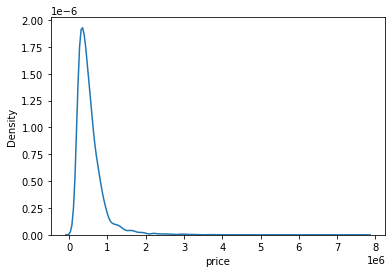

In [8]:
# y 분포확인하기
y=train['price']
sns.kdeplot(y)
plt.show()

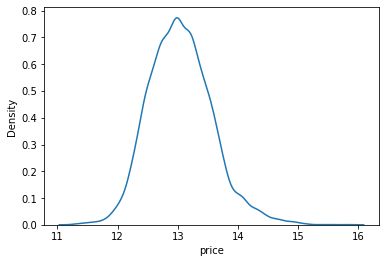

In [9]:
# 로그변환하기 => 나중에 모델이 값을 예측한 후에 다시 np.exp1m()을 활용해서 되돌려야 됨
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [10]:
# 로그변환하기
train['price']=np.log1p(train['price']) 

In [11]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,12.100718,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# training set에서 데이터 살펴보기

In [12]:
# info() 함수로 전체 데이터의 자료형

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  int64  
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [13]:
cor_mat = train.corr()
train.corr()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.013261,0.035940,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,...,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
date,-0.013261,1.000000,0.009466,-0.002696,-0.022810,-0.022119,0.007500,-0.020891,-0.001742,0.013986,...,-0.023233,-0.019422,-0.009627,0.004517,-0.019625,-0.000763,-0.031683,0.002894,-0.014327,0.003511
price,0.035940,0.009466,1.000000,0.359946,0.552000,0.697907,0.108946,0.317810,0.172580,0.347506,...,0.707412,0.607197,0.314378,0.076293,0.127533,-0.039195,0.444417,0.054362,0.621800,0.096976
bedrooms,0.010520,-0.002696,0.359946,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,...,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,-0.022810,0.552000,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,...,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,-0.022119,0.697907,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,...,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.007500,0.108946,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,...,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,-0.020891,0.317810,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,...,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,-0.001742,0.172580,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,...,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.013986,0.347506,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,...,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501


In [14]:
# price에 대한 다른 변수들의 상관관계
cor_mat["price"].sort_values(ascending = False)

price            1.000000
grade            0.707412
sqft_living      0.697907
sqft_living15    0.621800
sqft_above       0.607197
bathrooms        0.552000
lat              0.444417
bedrooms         0.359946
view             0.347506
floors           0.317810
sqft_basement    0.314378
waterfront       0.172580
yr_renovated     0.127533
sqft_lot         0.108946
sqft_lot15       0.096976
yr_built         0.076293
long             0.054362
condition        0.042947
id               0.035940
date             0.009466
zipcode         -0.039195
Name: price, dtype: float64

# 데이터 설명 수정
[데이터설명링크](https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html)

20140521부터 20150514 까지의 부동산 거래 데이터

1. id - Unique ID for each home sold \ id : 집을 구분하는 번호
> 추후 삭제

2. date - Date of the home sale \ date : 거래 된 날짜

3. price - Price of each home sold \ price : 타겟 변수인 집의 가격
>정답데이터

4. bedrooms - Number of bedrooms \ bedrooms : 침실의 수
>범주형

5. bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower / full bath (1) : 화장실, 세면대, 샤워실, 욕조 \ 3/4 bath (0.75) : 화장실, 세면대, 샤워실 \ half bath (0.5) : 화장실, 세면대
>범주형

6. sqft_living - Square footage of the apartments interior living space \ sqft_living : 주거 공간의 평방 피트
>수치형

7. sqft_lot - Square footage of the land space \ sqft_lot : 부지의 평방 피트
>수치형

8. floors - Number of floors \ floors : 집의 층 수
>범주형

9. waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not \ waterfront : 강이 흐르는게 보이는지 여부
>원핫인코딩,범주형

10. view - An index from 0 to 4 of how good the view of the property was \ view : 집이 좋아 보이는 정도 (0 ~ 4)
>범주형

11. condition - An index from 1 to 5 on the condition of the apartment, \ condition : 집의 전반적인 상태 (1 ~ 5)
>범주형 

12. grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.. \ grade : 건축 및 디자인의 수준 (1 ~ 13) \ 1-3 : 미달 7 : 평균 수준 11-13 : 높은 수준
>범주형

13. sqft_above - The square footage of the interior housing space that is above ground level \ sqft_above : 지하실을 제외한 평방 피트 \
>수치형

14. sqft_basement - The square footage of the interior housing space that is below ground level \ sqft_basement : 지하실의 평방 피트
>수치형

15. yr_built - The year the house was initially built \ yr_built : 처음 집을 지은 년도
>수치형

16. yr_renovated - The year of the house’s last renovation \ yr_renovated : 가장 최근에 집을 재건축한 년도
>범주형

17. zipcode - What zipcode area the house is in \ zipcode : 우편번호
>범주형

18. lat - Lattitude \ 위도

19. long - Longitude \ 경도
>수치형
20. sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors\ 주변 15 가구 주거 공간 평방피트의 평균 \ sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) \
>수치형
21. sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors\ 주변 15 가구 부지 평방피트의 평균 \ sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
>수치형

# 수치형 변수 살펴보기

### 산점도&추세선 그래프


<AxesSubplot:xlabel='sqft_living', ylabel='price'>

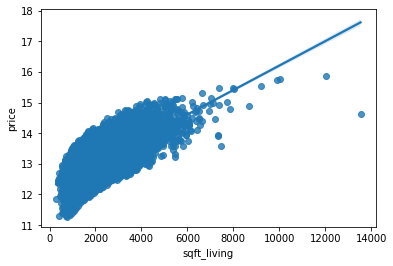

In [15]:
# 1. sqft_living : 주거 공간의 평방 피트

sns.regplot(x='sqft_living', y='price', data=train)

+ 양의 상관관계를 가지고 있다
+ (12000~14000)에서 추세선을 이탈하는 값이 있는데 이상치라고 생각한다
+ sqft_living(주거공간평방피트)= sqft_above(지하실을 제외한 평방 피트) + sqft_basement(지하실의 평방 피트) 를 만족함

<AxesSubplot:xlabel='yr_built', ylabel='price'>

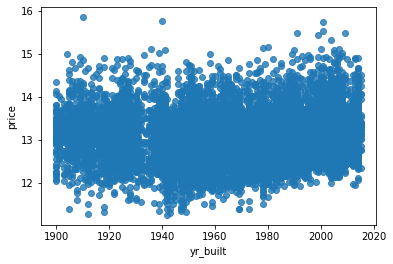

In [16]:
# 2. yr_built 집을 지은 년도
sns.regplot(x='yr_built', y='price', data=train)

+ 집을 지은 년도와 가격은 큰 차이가 없다

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

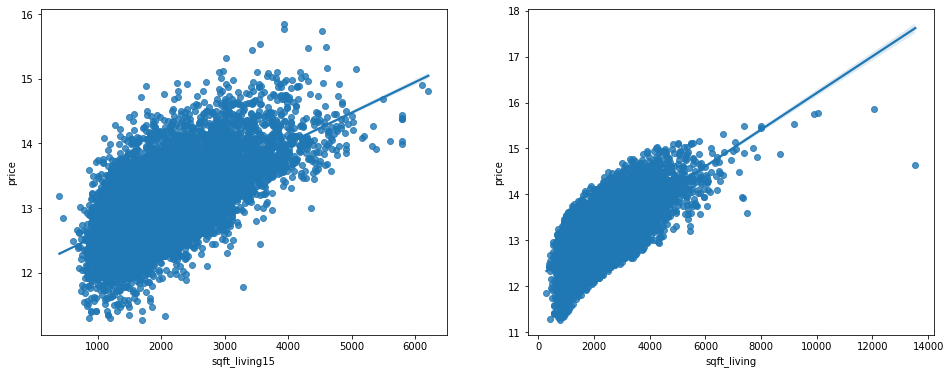

In [17]:
# 3. sqft_living15 & spft_living 비교

f, ax = plt.subplots(1,2,figsize=(16, 6))
sns.regplot(x='sqft_living15', y='price', data=train,ax=ax[0])
sns.regplot(x='sqft_living', y='price', data=train,ax=ax[1])

+ sqft_living(기존 주거 공간 평방 피트) 와 sqft_living15(15개 집의 주거공간의 평방 피트)는 비슷한 상관관계를 보인다.

# 범주형 변수 살펴보기

## boxplot

<AxesSubplot:xlabel='grade', ylabel='price'>

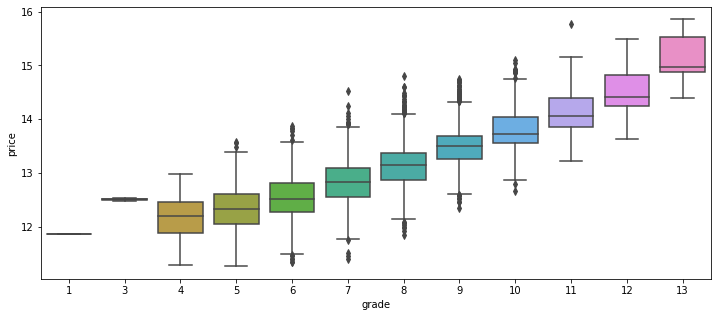

In [18]:
# 1. grade 

f, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(x='grade', y='price', data=train)

+ 등급이 높을수록 가격이 높다
+ 3등급에서 4등급보다 높아 이상치라고 생각한다.

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

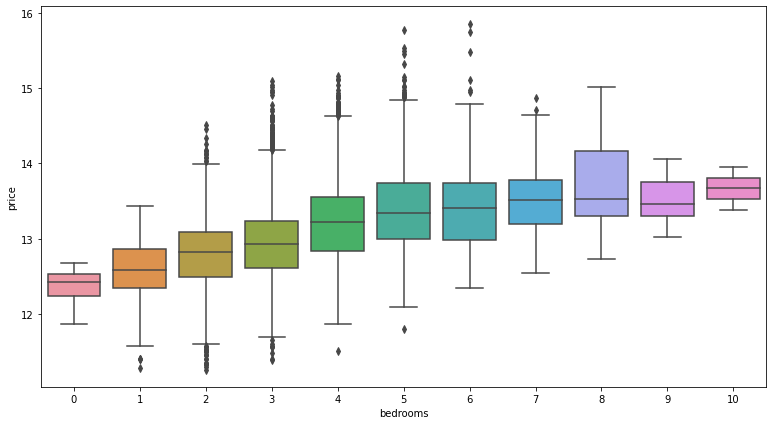

In [19]:
#2.bedrooms

f, ax = plt.subplots(figsize=(13, 7))
sns.boxplot(x='bedrooms', y='price', data=train)

+ 침실 수가 늘어날수록 가격이 높다


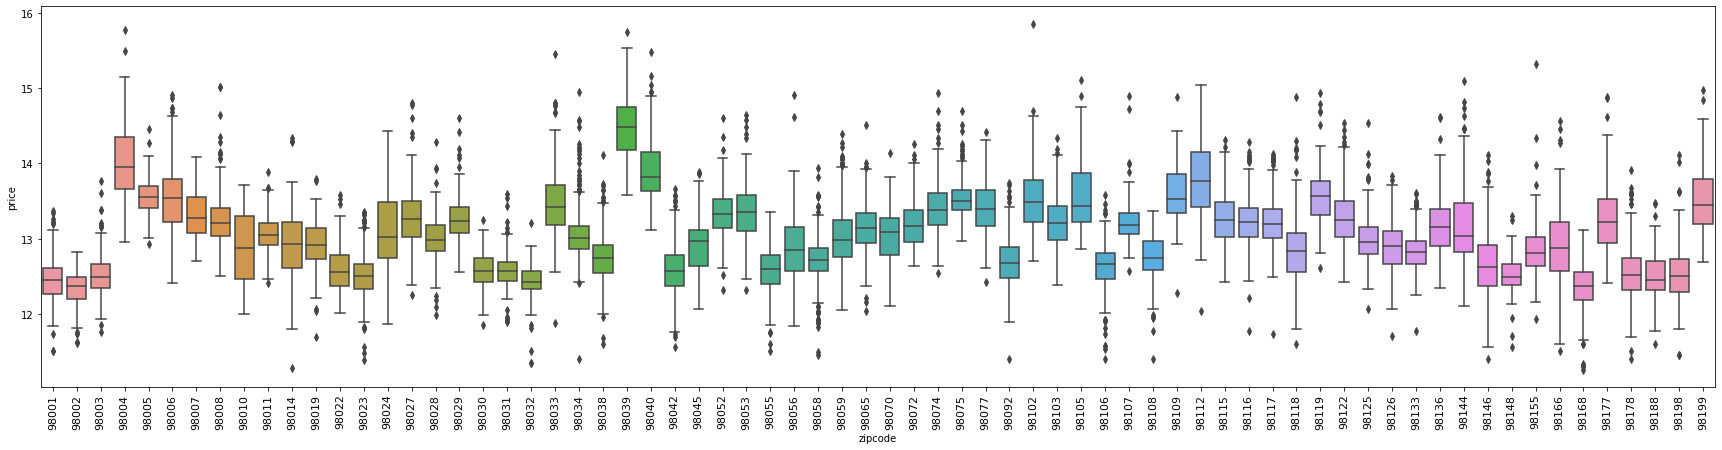

In [20]:
# 5. zipcode : 우편번호

f, ax = plt.subplots(figsize=(30, 7))
sns.boxplot(x='zipcode', y='price', data=train)
plt.xticks(rotation=90, fontsize=11)
plt.show()

+ 이 자료로 상관관계를 구하는 것은 힘들다
+ 우편번호와 집의위치(위도 경도)의 관계에 대해서 알아볼 필요가 있고 생각한다

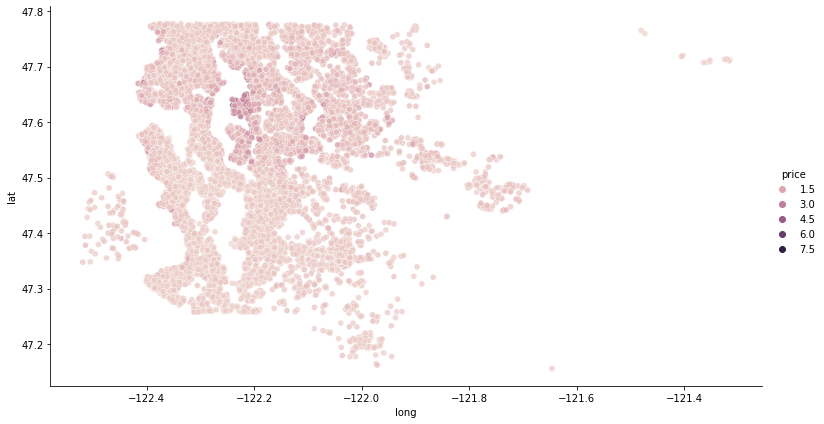

In [21]:
sns.relplot(x = 'long', y = 'lat', hue = 'price', alpha = 0.7, height = 6, aspect = 1.8, data = data)

# 지역에 따라 집값에 유의미한 차이가 있기는 한 것 같은데 
# 위경도의 특징을 한번에 나타내는 피처를 어떻게 뽑아내야 할지 모르겠다

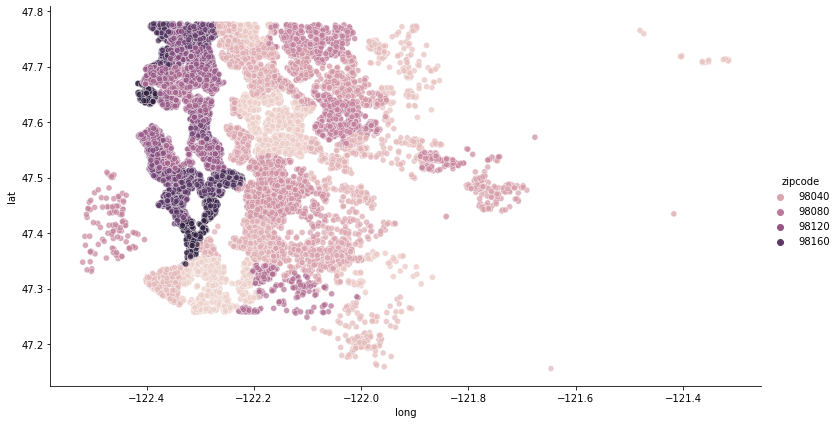

In [22]:
sns.relplot(x = 'long', y = 'lat', hue = 'zipcode', alpha = 0.7, height = 6, aspect = 1.8, data = data)

# 지역에 따라 집값에 유의미한 차이가 있기는 한 것 같은데 
# 위경도의 특징을 한번에 나타내는 피처를 어떻게 뽑아내야 할지 모르겠다

# 2. 전처리 과정

## 2-1 결측치 확인

<AxesSubplot:>

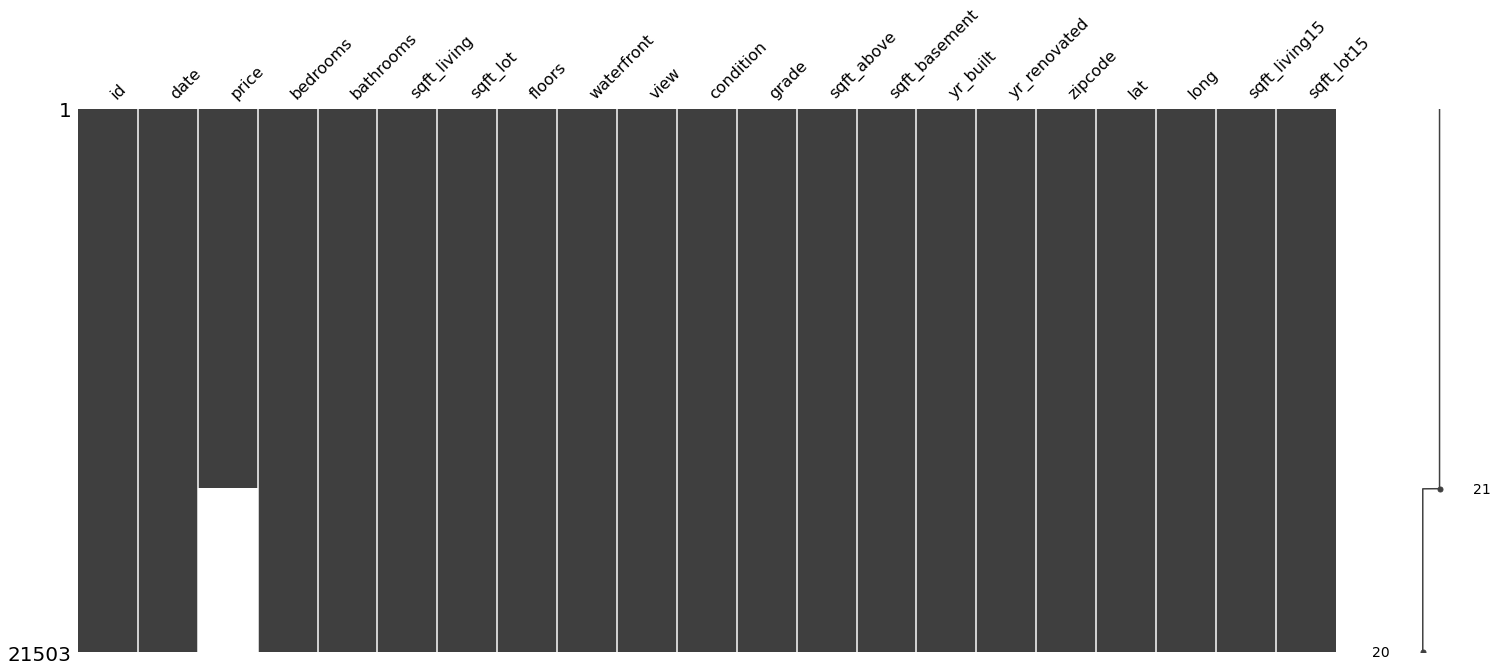

In [23]:
msno.matrix(data)

## 2-2. 이상치 확인

1. sqft_living : 주거 공간의 평방 피트
이상치 확인 후 제거


<AxesSubplot:xlabel='sqft_living', ylabel='price'>

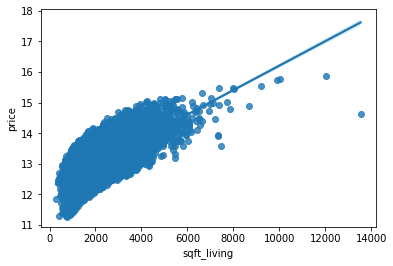

In [24]:
sns.regplot(x='sqft_living', y='price', data=train)

In [25]:
# 130000보다 큰 경우 확인
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [26]:
train = train[train['sqft_living'] != 13540]

In [27]:
train.loc[train['sqft_living'] > 13000] # 이상치 제거 완료

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [28]:
# id column 삭제

del train['id']
del test['id']

In [29]:
# 이상치 제거한 training set과 testset 합치기
# train test 값이 같아야 한다

train_len = len(train)
data = pd.concat((train, test), axis=0)
train_len

15034

## 2-3. 데이터 변환

In [30]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21502 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21502 non-null  int64  
 1   price          15034 non-null  float64
 2   bedrooms       21502 non-null  int64  
 3   bathrooms      21502 non-null  float64
 4   sqft_living    21502 non-null  int64  
 5   sqft_lot       21502 non-null  int64  
 6   floors         21502 non-null  float64
 7   waterfront     21502 non-null  int64  
 8   view           21502 non-null  int64  
 9   condition      21502 non-null  int64  
 10  grade          21502 non-null  int64  
 11  sqft_above     21502 non-null  int64  
 12  sqft_basement  21502 non-null  int64  
 13  yr_built       21502 non-null  int64  
 14  yr_renovated   21502 non-null  int64  
 15  zipcode        21502 non-null  int64  
 16  lat            21502 non-null  float64
 17  long           21502 non-null  float64
 18  sqft_li

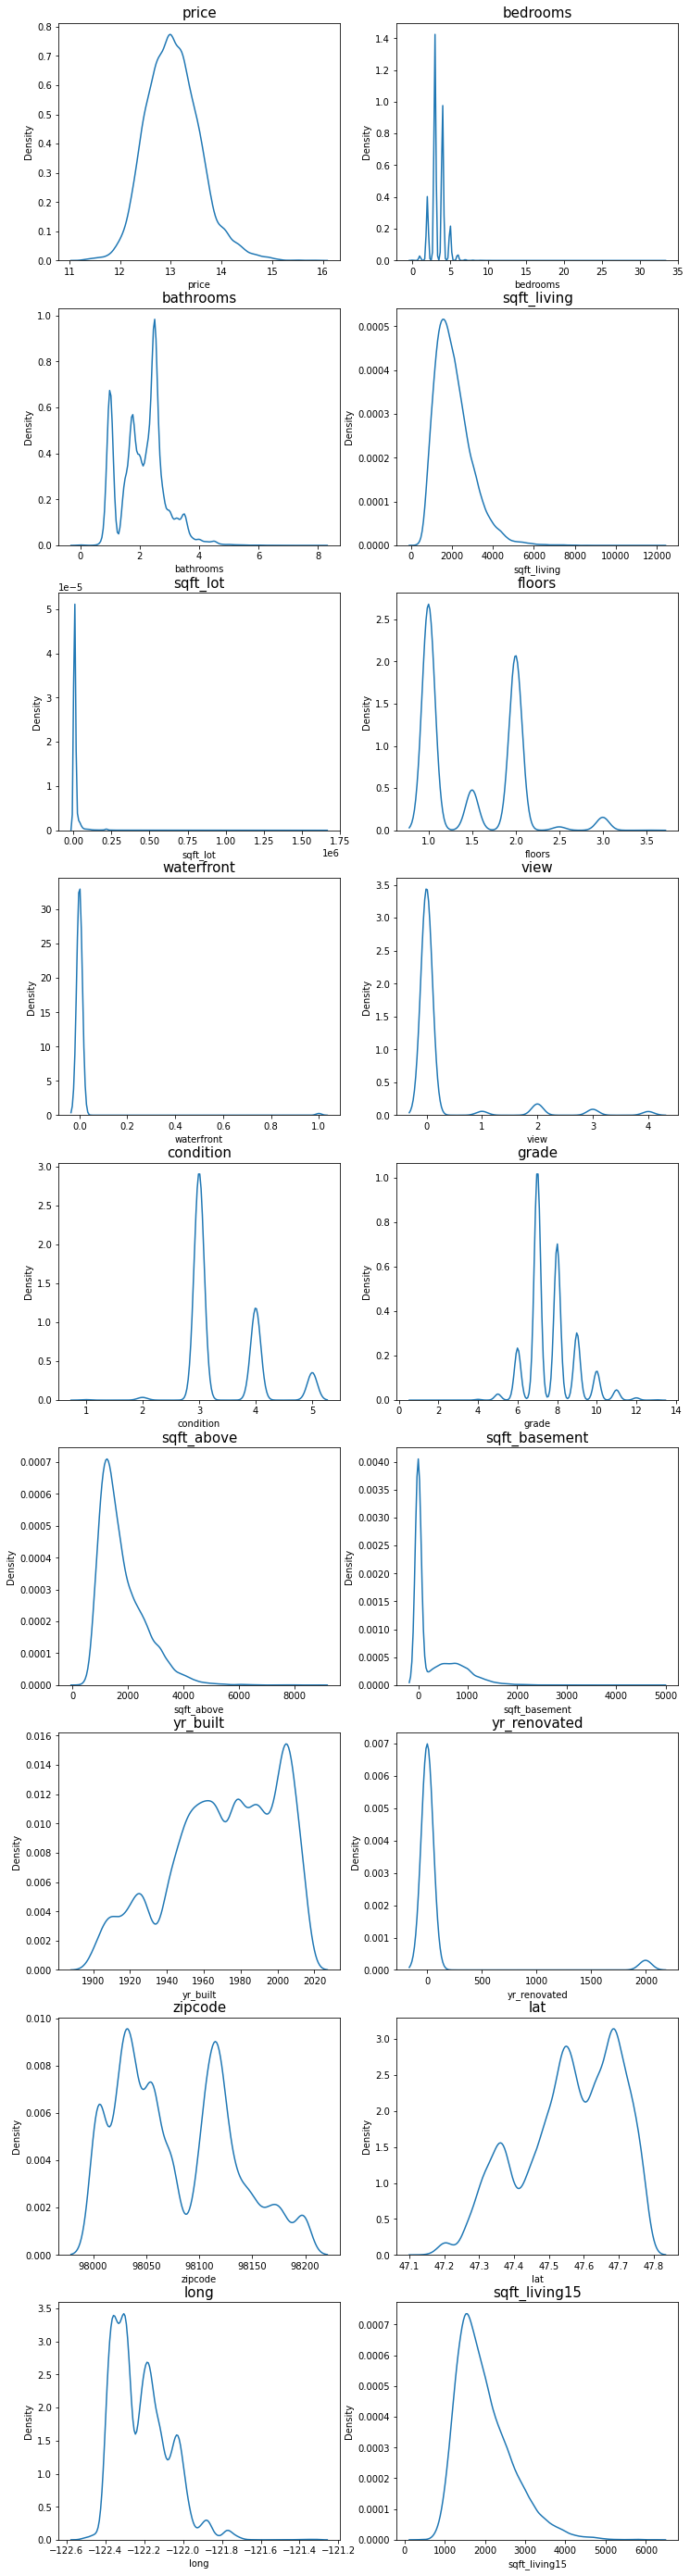

In [32]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(10):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        
    if count == 19 :
        break

In [33]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

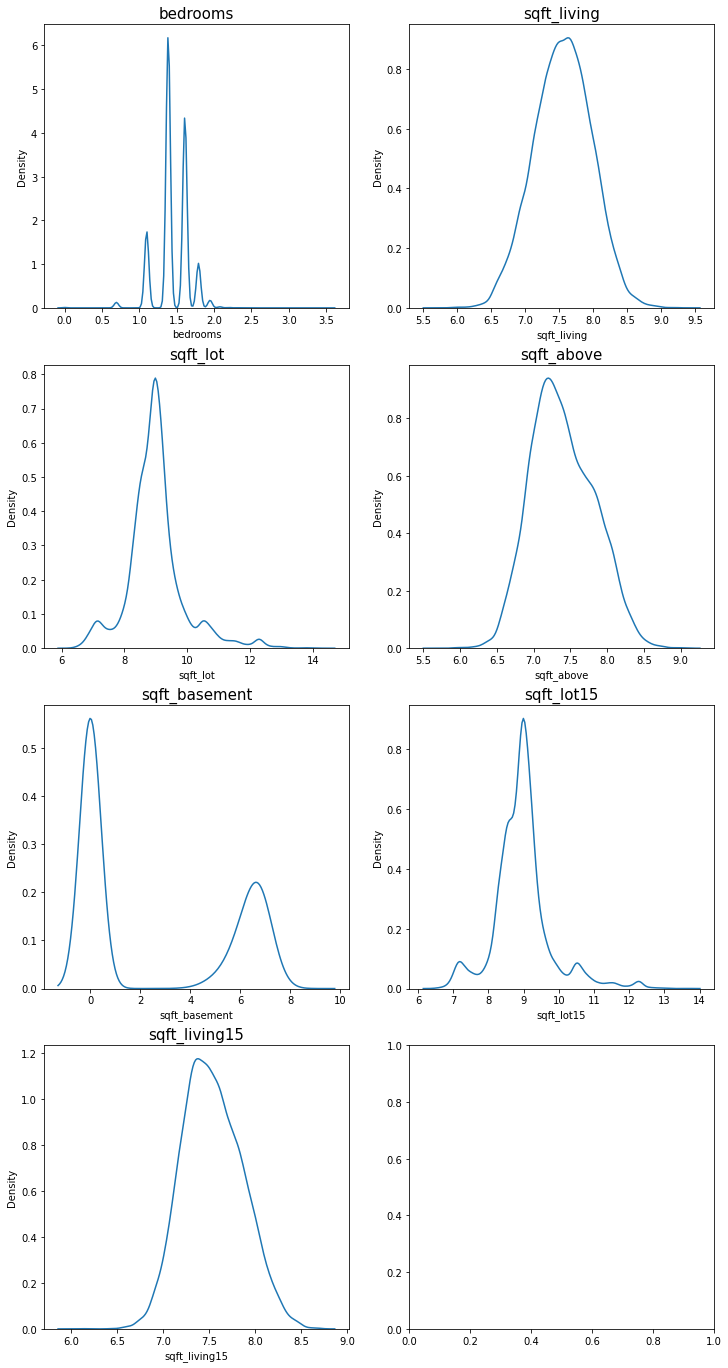

In [34]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [35]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,12.309987,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,12.100718,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,13.142168,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,12.458779,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,12.583999,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


# 3.모델링

## X_train, X_test, y_train 만들기

In [36]:
# test, train set 나누기
test= data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

In [37]:
# target
y_train=train['price']


In [38]:
#데이터에서 price 제거
train.drop('price', axis=1, inplace=True)
test.drop('price', axis=1, inplace=True)

In [39]:
X_train = train
X_test = test

In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15034 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15034 non-null  int64  
 1   bedrooms       15034 non-null  float64
 2   bathrooms      15034 non-null  float64
 3   sqft_living    15034 non-null  float64
 4   sqft_lot       15034 non-null  float64
 5   floors         15034 non-null  float64
 6   waterfront     15034 non-null  int64  
 7   view           15034 non-null  int64  
 8   condition      15034 non-null  int64  
 9   grade          15034 non-null  int64  
 10  sqft_above     15034 non-null  float64
 11  sqft_basement  15034 non-null  float64
 12  yr_built       15034 non-null  int64  
 13  yr_renovated   15034 non-null  int64  
 14  zipcode        15034 non-null  int64  
 15  lat            15034 non-null  float64
 16  long           15034 non-null  float64
 17  sqft_living15  15034 non-null  float64
 18  sqft_l

## test set, validation set 나누기

In [41]:
# test set, validation set 나누기
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=111)

In [42]:
# 모델 불러오기 
model = LGBMRegressor(random_state=111)

model2= XGBRegressor(random_state=111)

In [43]:
# LGBM 파라미터 설정
parameters = {
    'objective':['regression'],
    'num_leaves' : [1,5,7,9],
    'learning_rate' : [0.05,0.1],
    'n_estimators':[900,1000,1500],
    'max_bin' : [70,80],
    'boosting_type':['gbdt','rf'],
    'max_depth' :[7,9,10 ]
}

In [44]:
# XGBoost 파라미터 설정
X_parameters = {
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],        
    'n_estimators':[1000]
}

In [45]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=3, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [46]:
my_GridSearch(model, x_train, y_train, parameters, verbose=2, n_jobs=5)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=5, objective=regression; total time=   1.8s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=5, objective=regression; total time=   1.4s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=7, objective=regression; total time=   2.7s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=5, object

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=7, objective=regression; total time=   1.5s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=9, objective=regression; total time=   1.6s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=5, objective=regression; total time=   1.6s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=9, objective=regression; total time=   1.9s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=5, objective=regression; total time=   2.1s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=7, objectiv

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=7, objective=regression; total time=   2.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=9, objective=regression; total time=   2.6s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=7, objective=regression; total time=   1.7s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=9, objective=regression; total time=   1.7s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=7, objective=regression; total time=   3.2s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=9, objectiv

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=5, objective=regression; total time=   1.4s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=7, objective=regression; total time=   1.5s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=900, num_leaves=9, objective=regression; total time=   1.6s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=7, objective=regression; total time=   1.5s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1000, num_leaves=9, objective=regression; total time=   1.8s
[CV] END boosting_type=gbdt, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=7, objective

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fata

[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=9, n_estimators=1000, num_leaves=7, objective=regression; total time=   1.5s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=9, n_estimators=1000, num_leaves=9, objective=regression; total time=   1.9s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=9, n_estimators=1500, num_leaves=7, objective=regression; total time=   2.4s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=9, n_estimators=1500, num_leaves=9, objective=regression; total time=   3.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=900, num_leaves=7, objective=regression; total time=   1.4s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1000, num_leaves=1, objective=

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && c

[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1000, num_leaves=9, objective=regression; total time=   1.8s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=5, objective=regression; total time=   2.1s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=7, objective=regression; total time=   2.3s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=900, num_leaves=5, objective=reg

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->baggi

[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=5, objective=regression; total time=   2.8s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=10, n_estimators=1500, num_leaves=9, objective=regression; total time=   2.6s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=900, num_leaves=5, objective=regression; total time=   1.9s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=900, num_leaves=7, objective

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->baggi

[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=5, objective=regression; total time=   2.1s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=7, objective=regression; total time=   3.6s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=9, n_estimators=900, num_leaves=5, objective=regression; total time=   1.9s
[CV] END boosting_type=gbdt, learning_rate=0.1, max_bin=70, max_depth=9, n_estimators=900, num_leaves=7, objective=regr

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->baggi

[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=5, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=5, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=5, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=7, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=7, n_estimators=1500, num_leaves=9, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=9, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=70, max_depth=9, n_estimators=900, num_leaves=5, objective=regression;

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/con

[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=900, num_leaves=9, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=7, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=7, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=9, objective=regression

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/bo

[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=9, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=9, n_estimators=1500, num_leaves=9, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=10, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=10, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=10, n_estimators=900, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=10, n_estimators=900, num_leaves=9, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=10, n_estimators=1000, num_leaves=1, objective=regressi

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check 

[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=7, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=7, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=9, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=9, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.05, max_bin=80, max_depth=9, n_estimators=900, num_leaves=9, objective=regression

,boosting_type,learning_rate,max_bin,max_depth,n_estimators,num_leaves,objective,score,RMSLE
71,gbdt,0.05,80,10,1500,9,regression,-0.026694,0.163382
59,gbdt,0.05,80,9,1500,9,regression,-0.026694,0.163382
141,gbdt,0.10,80,10,1500,5,regression,-0.026755,0.163570
117,gbdt,0.10,80,7,1500,5,regression,-0.026755,0.163570
129,gbdt,0.10,80,9,1500,5,regression,-0.026755,0.163570
...,...,...,...,...,...,...,...,...,...
283,rf,0.10,80,10,1000,9,regression,NaN,NaN
284,rf,0.10,80,10,1500,1,regression,NaN,NaN
285,rf,0.10,80,10,1500,5,regression,NaN,NaN
286,rf,0.10,80,10,1500,7,regression,NaN,NaN


In [47]:
my_GridSearch(model2, x_train, y_train, X_parameters, verbose=2, n_jobs=5)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=10, n_estimators=1500, num_leaves=9, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=1000, num_leaves=9, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=1, objective=regression; total time=   0.0s
[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=7, n_estimators=1500, num_leaves=9, objective=regression; total time=   0.1s
[CV] END boosting_type=rf, learning_rate=0.1, max_bin=80, max_depth=9, n_estimators=900, num_leaves=1, objective=regression; tota

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,score,RMSLE
0,0.5,0.05,5,1000,0.9,-0.026105,0.161569


In [48]:
# LGBMRegressor  best parameter 적용
model = LGBMRegressor(max_bin=70,max_depth=10, n_estimators=1500,objective='regression',learning_rate=0.1,boosting_type='gbdt',num_leaves=5,min_child_samples=24 ,random_state=111)

In [49]:
# XGBRegressor  best parameter 적용
model2 =XGBRegressor(max_depth=5,colsample_bytree=0.5, n_estimators=1000,learning_rate=0.05,subsample=0.9,random_state=111)

# 학습하기


In [50]:
model.fit(x_train, y_train)
model2.fit(x_train, y_train)

pred = model.predict(x_val)
pred2 = model2.predict(x_val)

score1=np.sqrt(mean_squared_error(y_val,pred))
print('LGBMoboost 스코어 : {0:.4f}'.format(score1))
score2=np.sqrt(mean_squared_error(y_val,pred2))
print('XGBoboost 스코어 : {0:.4f}'.format(score2))

LGBMoboost 스코어 : 0.1601
XGBoboost 스코어 : 0.1565


# test set 예측하기


In [51]:
# LGBMRegressor
testpred = model.predict(test)
testpred = np.expm1(testpred)
# XGBRegressor 
testpred2 = model2.predict(test)
testpred2 = np.expm1(testpred2)

# 앙상블

In [52]:
preds = 0.5* testpred + 0.5*testpred2

In [53]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = preds
submission_csv_path = '{}/submission_{}.csv'.format(data_dir, 'try_zipcode_grid')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))

/aiffel/aiffel/kaggle_kakr_housing/data/submission_try_zipcode_grid.csv saved!


# 회고


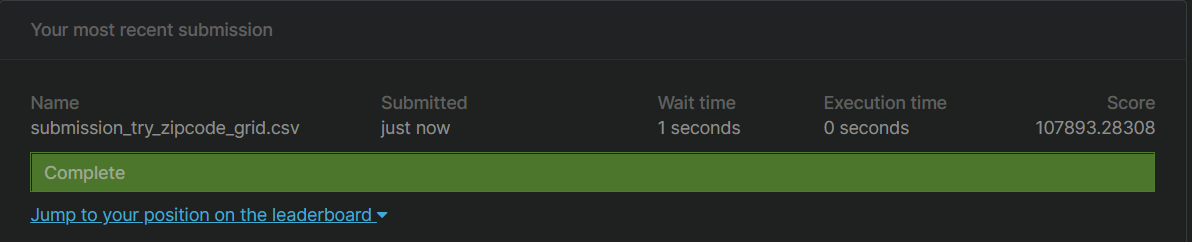




## 모델 공부

# 1.XGBoost 개념 이해
## Boosting이란?
+ 여러 개의 약한 Decision Tree를 조합해서 사용하는 Ensemble 기법 중 하나이다.
    + 즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만드는 것이다.
    
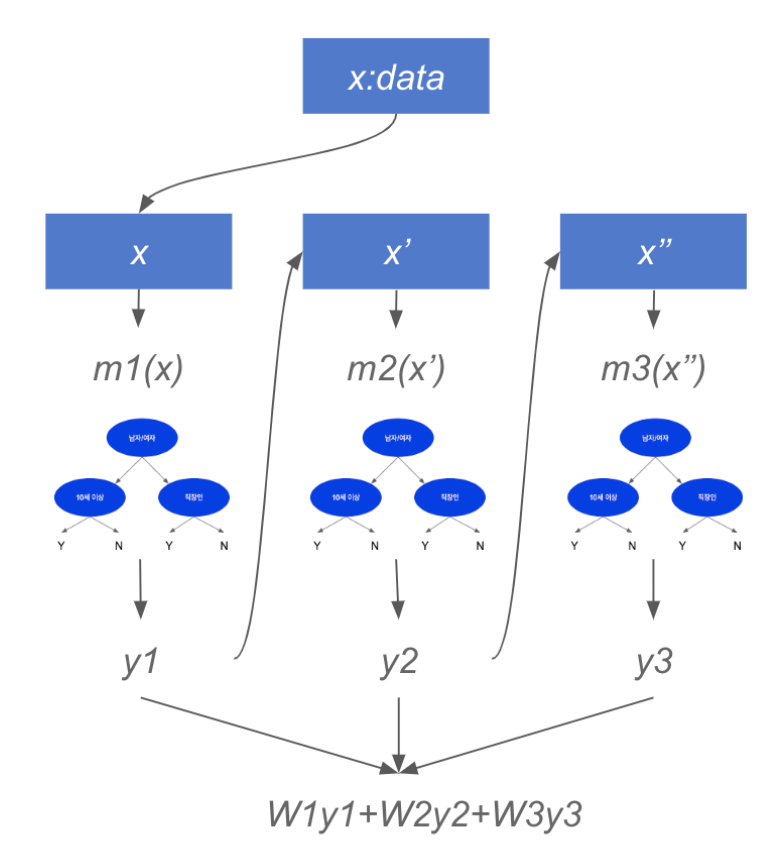

## XGBoost 란?
+ XGBoost는 Extreme Gradient Boosting의 약자이다.
+ Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적인데
+ 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost 이다.
+ Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘이다.


~~~python
# XGBoost 파라미터 설정
X_parameters = {
    'learning_rate': [0.05],
    'max_depth': [5],
    'subsample': [0.9],
    'colsample_bytree': [0.5],        
    'n_estimators':[1000]
}
~~~

### Xgboost
+ n_estimators [default = 100] : 나무의 개수
+ early_stopping_rounds :
    
    - 최대한 몇 개의 트리를 완성해볼 것인지 / valid loss에 더이상 진전이 없으면 멈춤
    
    - 과적합을 방지할 수 있음 => n_estimators 가 높을때 주로 사용.
+ learning_rate [default = 0.1] :
    
    - 학습 단계별로 가중치를 얼만큼 사용할지 결정/ 이전의 결과를 얼마나 반영할건지
    
    - 낮은 eta -> 낮은 가중치 -> 다음 단계의 결과물 적게 반영 -> 보수적
+ max_depth [default = 6] : 트리의 최대 깊이, 일반적으로 3 ~ 10
+ subsample [default = 1] : 각 트리마다 데이터 샘플링 비율, over-fitting 방지,일반적으로 0.5 ~ 1
+ colsample_bytree [default = 1] : 각 트리마다 feature 샘플링 비율, 일반적으로 0.5 ~ 1


# 2. LGBM 개념이해

## LGBM은 무엇인가?
+ LGBM은 Light GBM이다. Light하다는 것은 속도가 빠르고, 적은 메모리를 이용한다고 생각하면 된다. 당연히 GPU 가속기를 이용할 수 있다.

+ GBM은 Gradient Boosting Machine이다. 잔여오차(residual error)에 가중치를 gradient descent로 진행

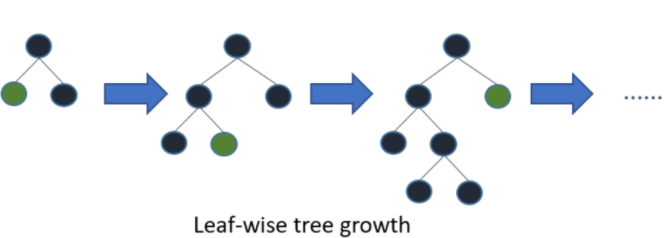
$$VS$$
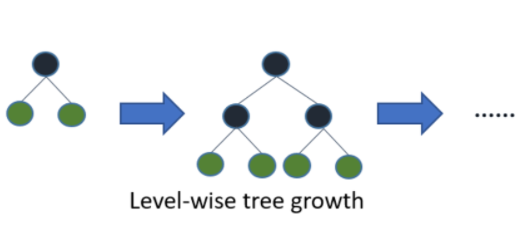

~~~python
# LGBM 파라미터 설정
parameters = {
    'objective':['regression'],
    'num_leaves' : [1,5,7,9],
    'learning_rate' : [0.05,0.1],
    'n_estimators':[900,1000,1500],
    'max_bin' : [70,80],
    'boosting_type':['gbdt','rf'],
    'max_depth' :[7,9,10 ]
}
~~~

### LightGBM (대부분의 파라미터는 XGBoost와 동일)
+ boosting :
    + rf (random forest)
    + gbdt (gradient boos decision tree)
    + dart (dropout regression tree)
    + goss (gradient based one-side sampling)
        
    
    + 기본값은 gbdt로 대부분 쓰이며, 정확도가 중요할때는 딥러닝 드랍아웃과 같은 dart적용, 그리고 논문에서 강조한 샘플링을 이용한 goss 를 적용가능
    + GOSS는 계산속도를 상당히 줄여주지만 약간의 예측력 손상(혹은 규제로 작용)이 있을 수 있음
    + DART는 일반적인 경우 조금 더 나은 예측력을 보여주지만, 절대적인건 아니다.
    
+ min_child_samples [default = 20] : 리프 노드가 되기 위한 최소한으로 필요한 레코드 수 / 큰 값 과적합 방지
+ num_leaves [default = 31] : 하나의 트리가 가질 수 있는 최대 리프 개수
+ max_depth : 다른 트리들과는 다르게 leaf wise 방식이기 때문에 깊이가 상대적으로 더 깊음


## 데이터분석 & 이상치제거
+ 데이터를 다양하게 분석하고 이상치라고 생각하는 것을 지정해보았다
+ 큰 값의 차이는 이상치라고 봐도 상관없지만 여러 요소에 의해 결정되는 이유로 이상치를 선정할때는 신중해야할 거 같다
